# Sample Point Creation ESM
Selects random sample of ESM3 data

#### Dask import

In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:37813")
client

<Client: 'tcp://127.0.0.1:37813' processes=4 threads=4, memory=25.77 GB>

<br>

#### Choices for data

In [2]:
#Experiment data for analysis
dataVariableId = 'thetao'
dataExperimentId = 'historical'
dataSourceID = 'E3SM-1-0'

#Custom Variables
latSel = slice(-89.5,-29.5) #Selected latitude to be investigated
levSel = slice(0, 2000)
maskName = "OceanMaskVolcello2"
lastESMDecade = slice('2005-01','2014-12')

<br>

#### Importing Libaries

In [3]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import dask.dataframe as dd
import fsspec
import matplotlib.dates as mdates
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as ticker
import xarray as xr
import zarr

from dask import delayed
from matplotlib.pyplot import cm
print("Imports complete")

Imports complete


<br>

#### Loading Data

In [4]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
dfFilt = df[df.variable_id.eq(dataVariableId) & df.experiment_id.eq(dataExperimentId) & df.source_id.eq(dataSourceID)]

zstore = dfFilt.zstore.values[0] #Opens first file only
mapper = fsspec.get_mapper(zstore)
fileRaw = xr.open_zarr(mapper, consolidated=True)

startDateIterate = np.datetime64(fileRaw['time'].values[0],'M')
endDateIterate = np.datetime64(fileRaw['time'].values[-1],'M') + np.timedelta64(1,'M')
fileRaw['time']=('time', np.arange(startDateIterate, endDateIterate, dtype='datetime64[M]'))
fileRaw['time_bnds']=('time_bnds', np.arange(startDateIterate, endDateIterate, dtype='datetime64[M]')) 

dfESMLat = fileRaw.thetao.sel(lat=latSel) #Selection of latitude
#dfESMLatLev = dfESMLat
dfESMLatLev = dfESMLat.sel(lev=levSel) #Selects level data down to 2k
dfESMLatLevT = dfESMLatLev.sel(time=lastESMDecade)
dfESMLatLevT = dfESMLatLevT.reset_coords(drop=True) #Removes lev if single value

globalStartDate = dfESMLatLevT["time"][0].values
globalDateInc = dfESMLatLevT["time"][1].values - globalStartDate
#np.datetime64(globalDateInc,'D')
globalEndDateIn = dfESMLatLevT["time"][-1].values
globalEndDateOut = globalEndDateIn + globalDateInc

globalStartDateStr = str(globalStartDate)[:7]
globalEndDateInStr = str(globalEndDateIn)[:7]
globalEndDateOutStr = str(globalEndDateOut)[:7]

print("ESM3 data loaded and stored in dfESMLatLevT")
#dfESMLatLevT #Uncomment to see data set

ESM3 data loaded and stored in dfESMLatLevT


In [5]:
maskFile = xr.open_dataset(maskName)
oceanMask = maskFile.to_array()
print("Mask data loaded into oceanMask.")

Mask data loaded into oceanMask.


<br>

#### Calculation Functions
<b>Functions:</b><br>
<ul>
<li>pickRand - Takes in data frame and returns sampled data frame with a randomly selected number of rows from the input data frame, controled by the second input variable to the function.
</ul>

In [6]:
def pickRand(dataFrame, locationArray, sampleNumbers):
    timeLen = len(dataFrame.time)
    geoLen = len(locationArray[0])
    frameSize = timeLen*geoLen
    timeRange = np.arange(np.datetime64(dataFrame.time[0].values, 'M'), np.datetime64(dataFrame.time[-1].values, 'M')+np.timedelta64(1, 'M'))
    
    if frameSize <= sampleNumbers: #More or equal samples are asked for than exist in the dataFrame
        print("Sample number is equal to or exceeds size of data frame, returning "+str(frameLen)+" data points.")
        return dataFrame
    else:
        sampleLatArray = np.empty(shape=(0), dtype= object) #Empty export array for sample latitudes
        sampleLonArray = np.empty(shape=(0)) #Empty export array for sample longitudes
        sampleTimeArray = np.empty(shape=(0,1), dtype = np.datetime64) #Empty export array for sample times
        sampleTempArray = np.empty(shape=(0,46)) #Empty export array for sample temperatures
        timeCap = sampleNumbers/timeLen #Calculates the number of samples for each time in timeRange
        
        geoID = np.random.choice(geoLen, sampleNumbers, False) #Select random samples
        
        for i in range(sampleNumbers):
            latID = locationArray[0][geoID[i]]
            lonID = locationArray[1][geoID[i]]
            timeID = timeRange[int(i/timeCap)]
            
            sampleLatArray = np.append(sampleLatArray, latID)
            sampleLonArray = np.append(sampleLonArray, lonID)
            sampleTimeArray = np.append(sampleTimeArray, timeID)
            
            #sampleData = dataFrame.sel(lat=latID, lon=lonID, time=timeID)
            #nan check for depth profile?#######################################################
            #sampleTempArray = np.append(sampleTempArray, sampleData) #computational
            sampleFullArray = np.array([sampleLatArray, sampleLonArray, sampleTimeArray], dtype=object)
            #sampleFullArray = np.array([sampleLatArray, sampleLonArray, sampleTimeArray, sampleTempArray], dtype=object)
            
        return sampleFullArray

print("Calculation functions defined")

Calculation functions defined


<br>
<b>Placing valid locations into an array</b><br>
Ocean mask here is used as it was generated from ESM3 data, however it would be more accurate to use the ESM sample data straight.

In [7]:
geoRangeLat = np.empty(shape=(0))
geoRangeLon = np.empty(shape=(0))
for i in range(61):
    for j in range(360):
        if not np.isnan(oceanMask[0][i][j]):
            geoRangeLat = np.append(geoRangeLat, oceanMask.lat[i])
            geoRangeLon = np.append(geoRangeLon, oceanMask.lon[j])
geoRange = np.append([geoRangeLat], [geoRangeLon], axis = 0) #Merges lat and lon arrays together into singular array
print("Valid locations identified and stored in geoRange")
#geoRange #Uncomment to see data array

Valid locations identified and stored in geoRange


<br>

#### Plotting Functions
<b>Functions:</b><br>
<ul>
<li>locationPlotSimple - Plots locations of an input data array on a map.
<li>locationPlot - Plots locations of an input data array on a map with a colour scale for time.
<li>latDistribution - Plots latitude distribution of an input data array as a histogram.
<li>latDistributionCompare - Plots latitude distribution of two input data arrays against each other as histograms.
<li>lonDistribution - Plots longitude distribution of an input data array as a histogram.
<li>lonDistributionCompare - Plots longitude distribution of two input data arrays against each other as histograms.
<li>timeDistribution - Plots time distribution of an input data array as a histograt
</ul>

In [8]:
def locationPlotSimple(dataArray, size, plotNo):
    '''Plots locations of numpy arrays'''
    colours = {"2005":"Red", "2006":"Blue"}
    plt.figure(plotNo, figsize=size)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    plt.scatter(dataArray[1], dataArray[0], transform=ccrs.PlateCarree(), color = "Red")
    plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title("Sample Locations ("+str(len(dataArray[0]))+")")
    
def locationPlot(dataArray, size, plotNo):
    '''Plots locations of numpy arrays with date colour scheme'''
    plt.figure(plotNo, figsize=size)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    im = ax.scatter(dataArray[1], dataArray[0], transform=ccrs.PlateCarree(), c= mdates.date2num(dataArray[2]), cmap='brg')
    cb = plt.colorbar(im)
    loc = mdates.AutoDateLocator()
    cb.ax.yaxis.set_major_locator(loc)
    cb.ax.yaxis.set_major_formatter(mdates.ConciseDateFormatter(loc))
    plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title("Sample Locations ("+str(len(dataArray[0]))+")")
    
def latDistribution(dataArray, binSize, plotNo):
    '''Plots latitude distribution of input data array'''
    if not binSize: binSize = 2
    plt.figure(plotNo)
    latDistri = np.arange(-89.5, -29.4, binSize)
    plt.hist(dataArray[0], bins = latDistri)
    plt.title("Latitude distribution of data points (Bin size:"+str(binSize)+")")
    
def latDistributionCompare(dataArrayS, dataArrayO, binSize, plotNo):
    '''Plots and compares latitude distribution of input data arrays'''
    if not binSize: binSize = 2
    plt.figure(plotNo, figsize=(10,7))
    latDistri = np.arange(-89.5, -29.4, binSize)
    latWeightsS = np.ones_like(dataArrayS[0])/float(len(dataArrayS[0]))
    latWeightsO = np.ones_like(dataArrayO[0])/float(len(dataArrayO[0]))
    plt.hist(dataArrayS[0], bins = latDistri, weights = latWeightsS, alpha=0.5, label="Sampled data")
    plt.hist(dataArrayO[0], bins = latDistri, weights = latWeightsO, alpha=0.5, label="Original data")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title("Latitude distribution of data points compared to original data set distribution (Bin size:"+str(binSize)+")")
    
def lonDistribution(dataArray, binSize, plotNo):
    '''Plots longitude distribution of input data array'''
    if not binSize: binSize = 3
    plt.figure(plotNo)
    lonDistri = np.arange(0, 360.1, binSize)
    plt.hist(dataArray[1], bins = lonDistri)
    plt.title("Longitude distribution of data points (Bin size:"+str(binSize)+")")
    
def lonDistributionCompare(dataArrayS, dataArrayO, binSize, plotNo):
    '''Plots and compares longitude distribution of input data arrays'''
    if not binSize: binSize = 3
    plt.figure(plotNo, figsize=(10,7))
    lonDistri = np.arange(0, 360.1, binSize)
    lonWeightsS = np.ones_like(dataArrayS[1])/float(len(dataArrayS[1]))
    lonWeightsO = np.ones_like(dataArrayO[1])/float(len(dataArrayO[1]))
    plt.hist(dataArrayS[1], bins = lonDistri, weights = lonWeightsS, alpha=0.5, label="Sampled data")
    plt.hist(dataArrayO[1], bins = lonDistri, weights = lonWeightsO, alpha=0.5, label="Original data")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title("Longitude distribution of data points compared to original data set distribution (Bin size:"+str(binSize)+")")
    
def timeDistribution(dataArray, plotNo):
    plt.figure(plotNo)
    timeDistri = np.arange(np.datetime64("2005-01", "M"), np.datetime64("2015-02", "M")) #last date is excluded (max "2015-01"), 2014-12 needs monthly bin
    plt.hist(dataArray[2], bins = timeDistri)
    plt.title("Time distribution of data points")
    
    
print("Plotting functions defined")

Plotting functions defined


<br>

#### Testing GeoRange storage

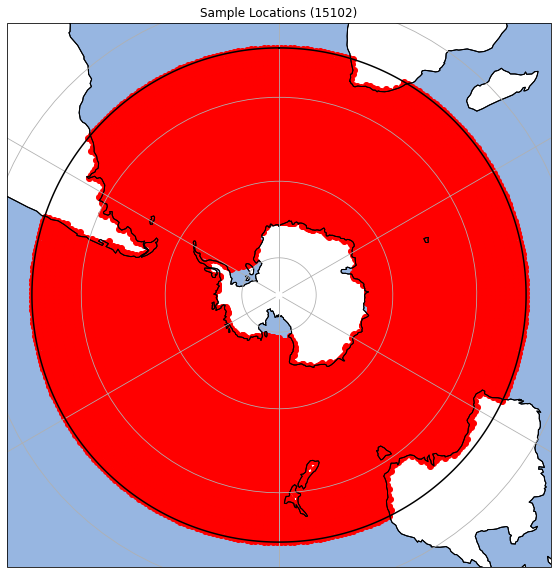

In [9]:
locationPlotSimple(geoRange, (10, 10), 1)

#### Displaying of data
<b>Demonstration of random sampling - 10 small scale samples</b>

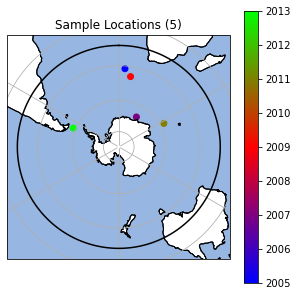

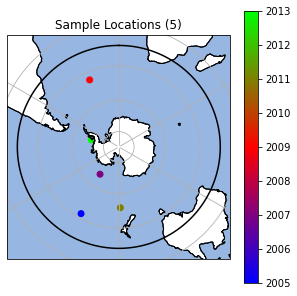

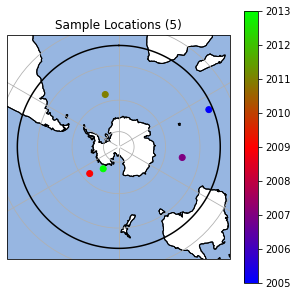

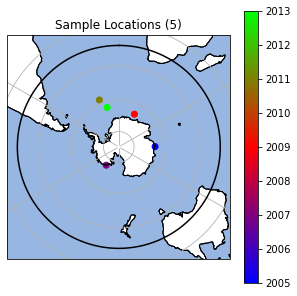

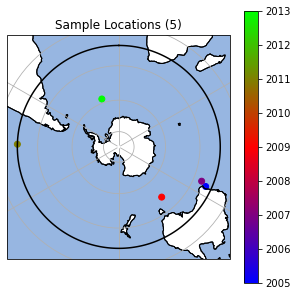

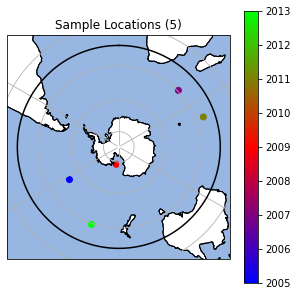

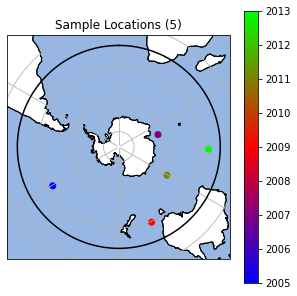

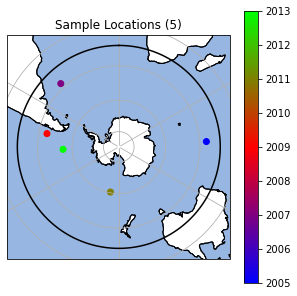

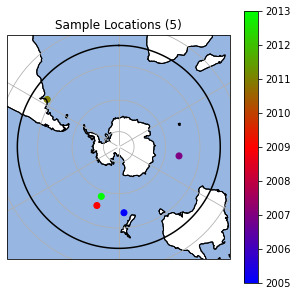

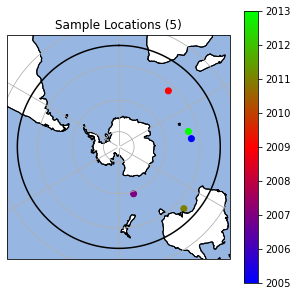

In [10]:
randomDataPointsList = []
for i in range(10):
    randomDataPoints = pickRand(dfESMLatLevT, geoRange, 5)
    randomDataPointsList.append(randomDataPoints)
    locationPlot(randomDataPoints, (5,5), i)

<br>
<b>Large Random Sample</b>

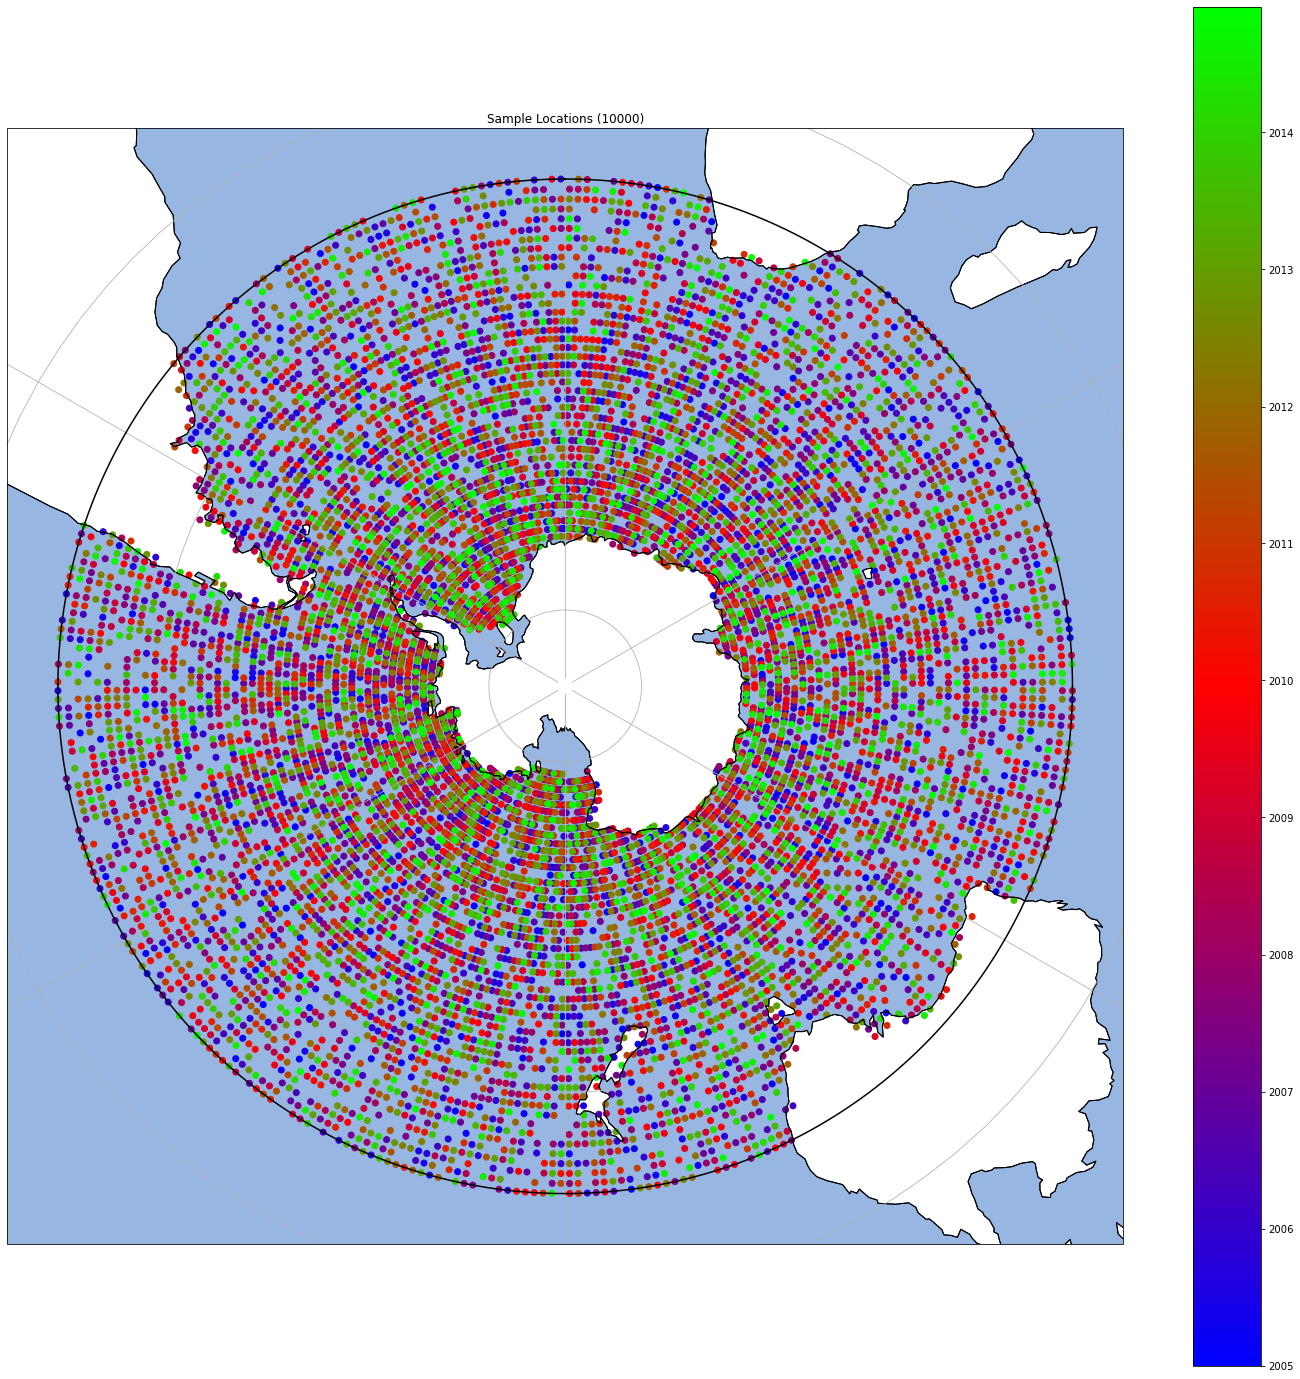

In [11]:
sampleDataPoints = pickRand(dfESMLatLevT, geoRange, 10000)
locationPlot(sampleDataPoints, (25,25), 1)

<br>
<b>Latitude and Longitude distribution of large sample</b>

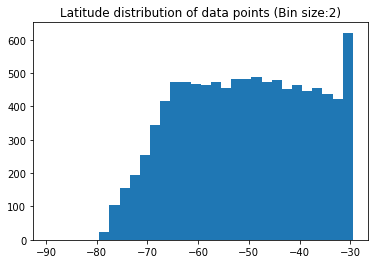

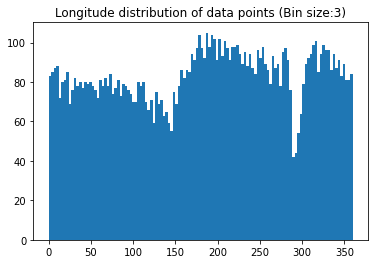

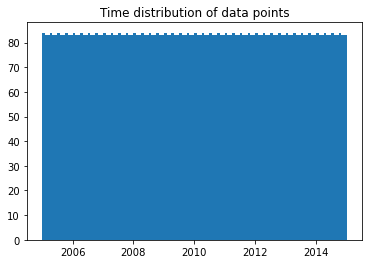

In [12]:
latDistribution(sampleDataPoints, 2, 1)
lonDistribution(sampleDataPoints, 3, 2)
timeDistribution(sampleDataPoints, 3)

<br>
<b>Latitude and Longitude distribution of large sample, compared to distributions of original data set</b>

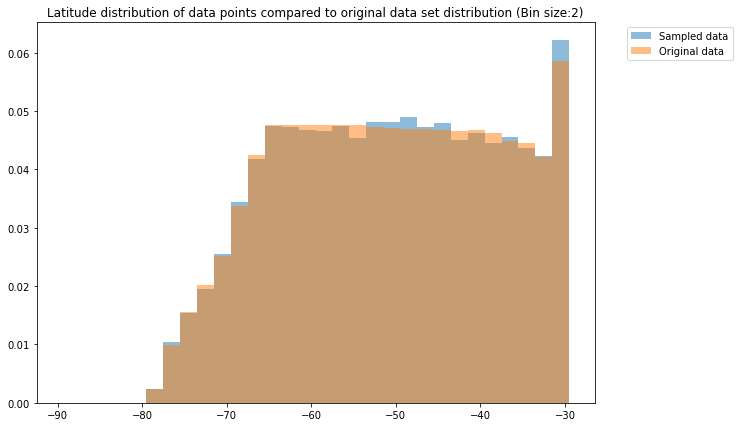

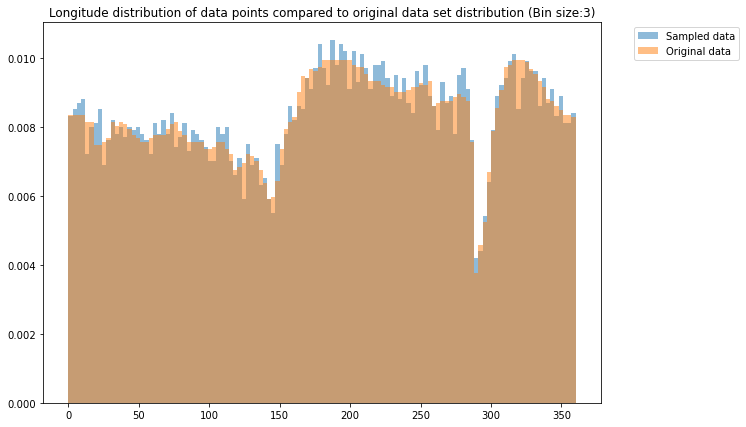

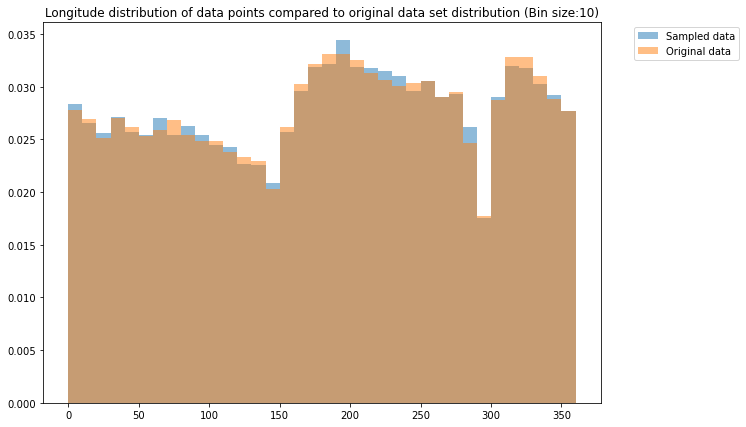

In [13]:
latDistributionCompare(sampleDataPoints, geoRange, 2, 1)
lonDistributionCompare(sampleDataPoints, geoRange, 3, 2)
lonDistributionCompare(sampleDataPoints, geoRange, 10, 3)

<br>
<b>Exporting Chosen Sample Time/Location Data</b>

In [14]:
np.save("GMMSampleTimeGeo", sampleDataPoints)
print("Data saved and exported to GMMSampleTimeGeo.npy")

Data saved and exported to GMMSampleTimeGeo.npy


<br>
<b>Reloading of Sample Time/Location Data file</b>

Reloaded data first, with original data below


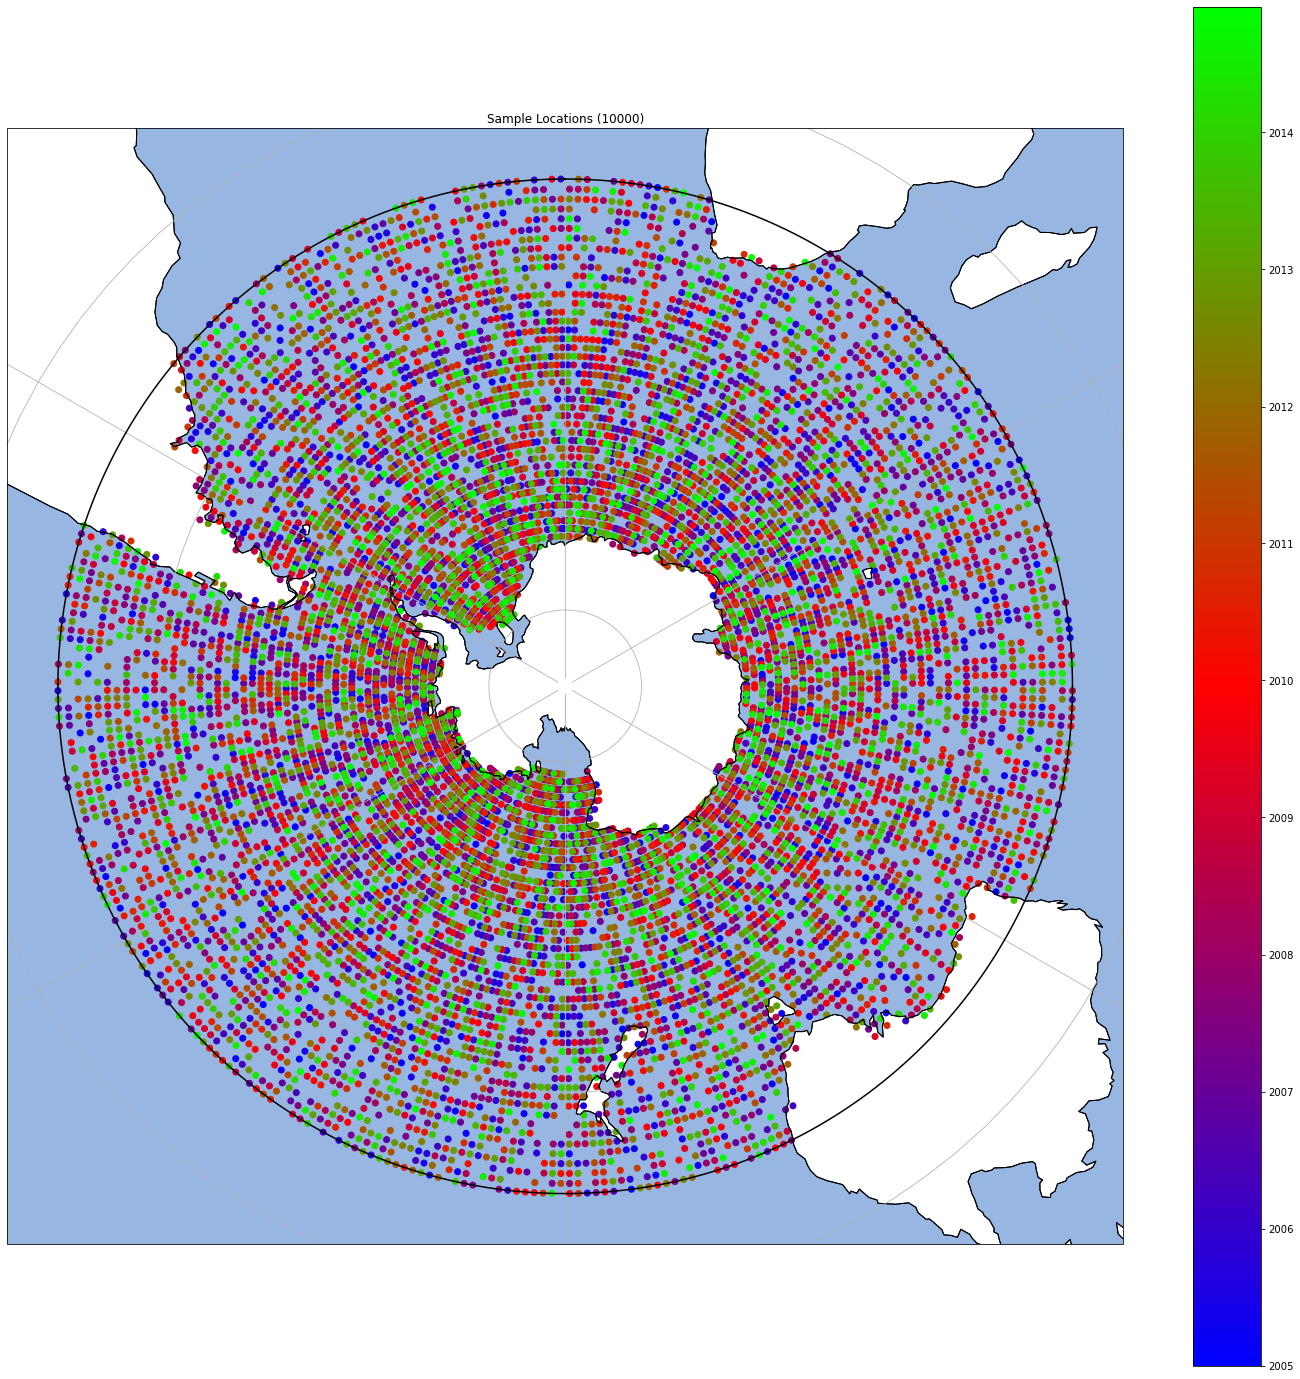

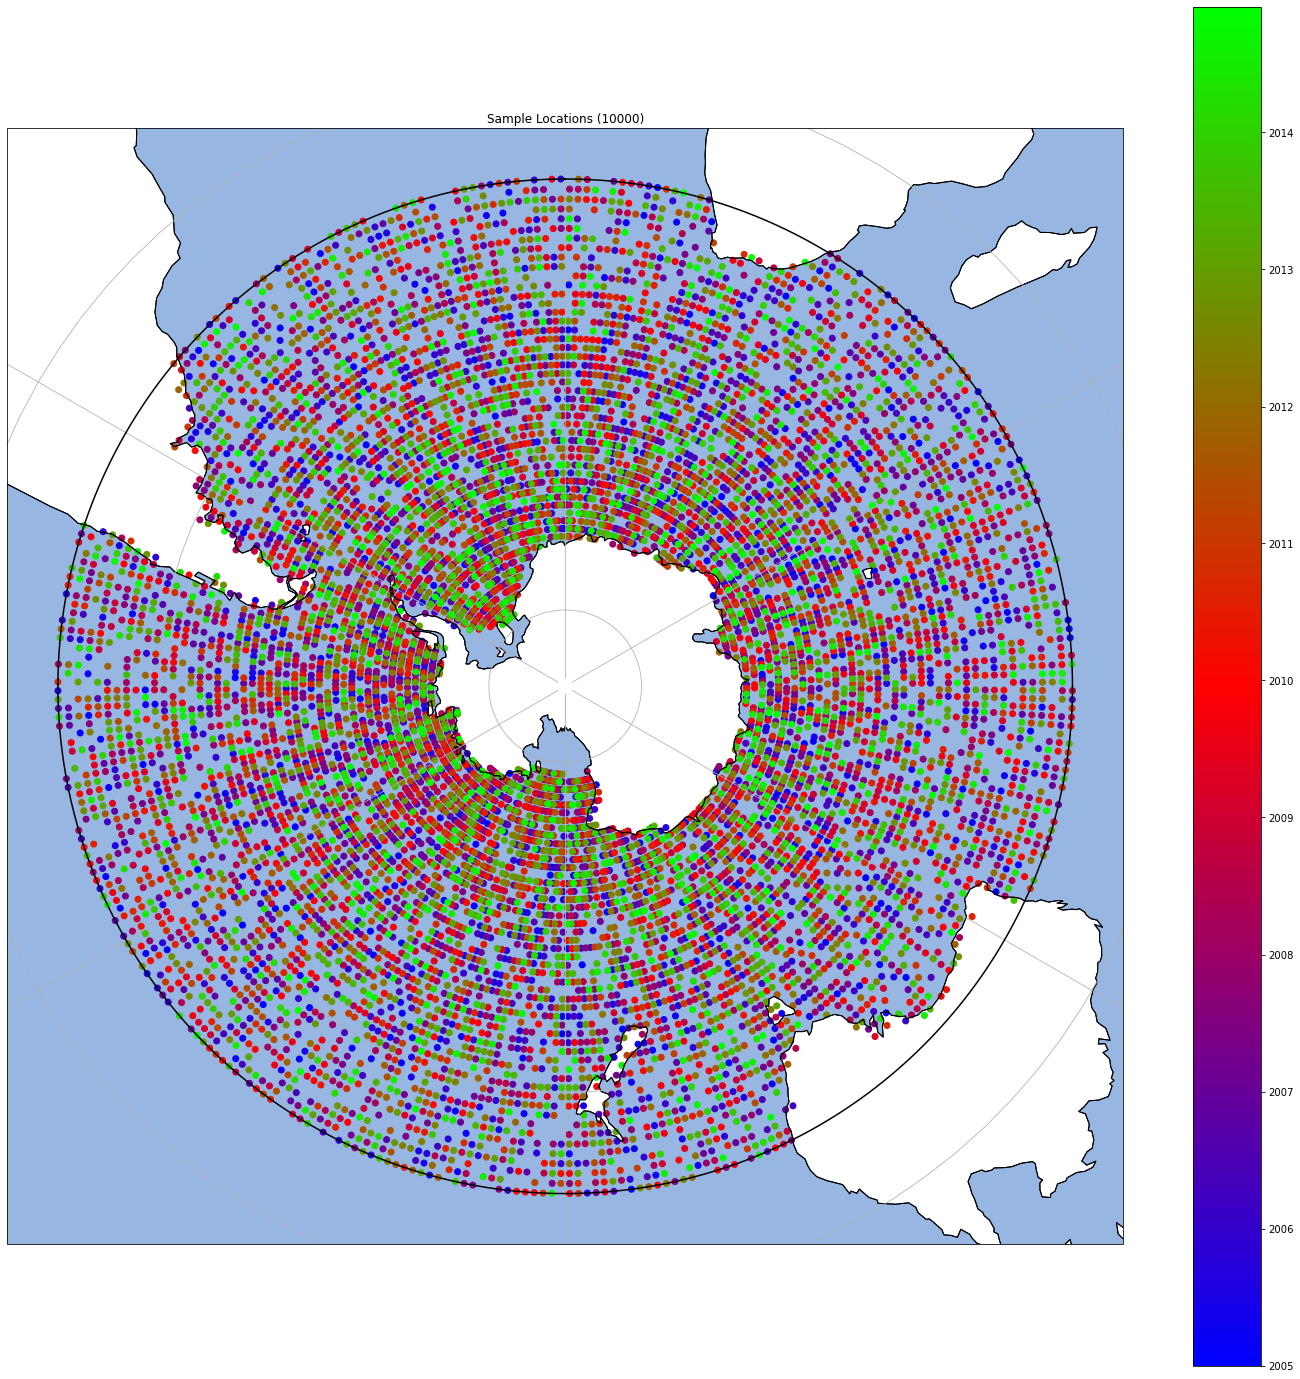

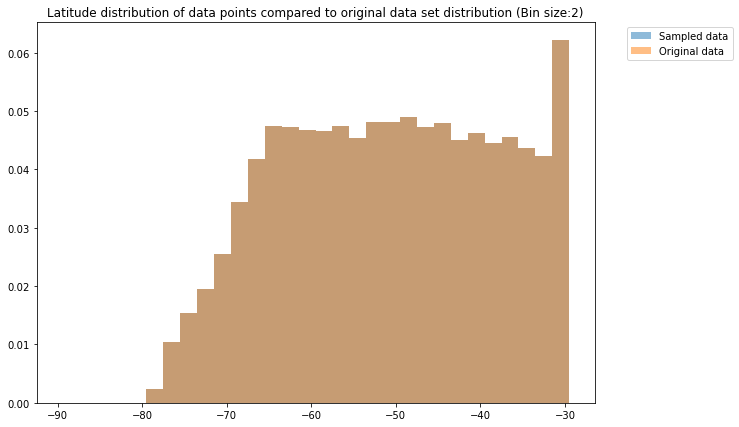

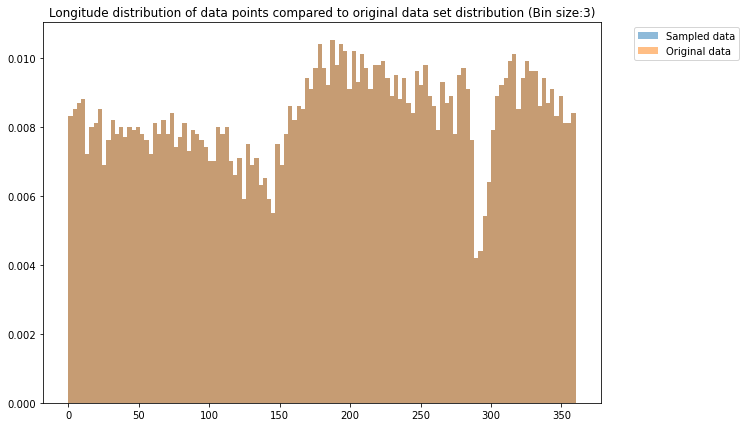

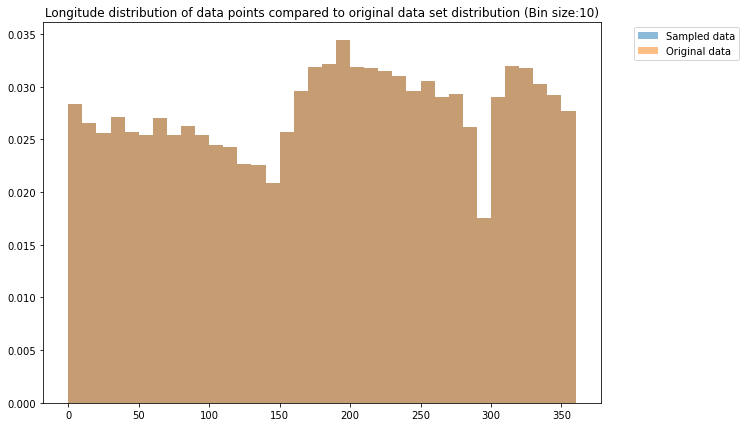

In [15]:
reloadSampleDataPoints = np.load("GMMSampleTimeGeo.npy", allow_pickle=True)
locationPlot(reloadSampleDataPoints, (25,25), 1)
print("Reloaded data first, with original data below")
locationPlot(sampleDataPoints, (25,25), 2)
latDistributionCompare(reloadSampleDataPoints, sampleDataPoints, 2, 3)
lonDistributionCompare(reloadSampleDataPoints, sampleDataPoints, 3, 4)
lonDistributionCompare(reloadSampleDataPoints, sampleDataPoints, 10, 5)